## Importing Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler  
from darts.models import Prophet
from bayes_opt import BayesianOptimization
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

## Reading and Preparing the Data

In [5]:
df = pd.read_csv("../data/Sunspots.csv")
df.drop(columns = ['Unnamed: 0'],inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df_idx = df.set_index(['Date'],drop=False)

## Defining the Prophet Model for Forecasting the Mean Monthly Sunspots

In [6]:
series = TimeSeries.from_dataframe(df_idx[:'1989'], 'Date', 'Monthly Mean Total Sunspot Number')  

In [7]:
#defining the model
def model_prophet(params):
    logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
    model =  Prophet(
        add_seasonalities=[
            {
            'name': '10_yr_cycle',  # (name of the seasonality component),
            'seasonal_periods': 12*11,  # (nr of steps composing a season),
            'fourier_order': params['ten_Y_fourier_order'],  # (number of Fourier components to use),
            'mode':'multiplicative',
            'prior_scale':params['tenY_seasonality_prior_scale']
            },
            {
            'name': 'yearly_cycle',  # (name of the seasonality component),
            'seasonal_periods': 12,  # (nr of steps composing a season),
            'fourier_order': params['yearly_fourier_order'],
            'mode':'additive',# (number of Fourier components to use),
            'prior_scale':params['yearly_seasonality_prior_scale']
            }
        ],
        changepoint_prior_scale = params['changepoint_prior_scale'],
    )

    model.fit(series)
    pred_series = model.predict(len(df_idx['1990':]))
    df_pred = TimeSeries.to_dataframe(pred_series).reset_index()
    df_pred.columns = ['Date','Monthly Mean Sunspot Predicted']
    df_pred = df_pred.set_index(['Date'],drop=False)
    return df_pred

In [8]:
#Combining the Predicted and Actual Values and Evaluating our Model
def model_mean_error(df_pred):
    df_pred['Month'] = df_pred['Date'].dt.to_period('M')
    df_idx['Month'] = df_idx['Date'].dt.to_period('M')
    df_pred = df_pred.merge(df_idx,on='Month',how='inner')
    df_pred.rename(columns = {'Date_y':'Date','Monthly Mean Total Sunspot Number':'Monthly Mean Sunspot Actual'},inplace=True)
    df_pred['mae'] = abs(df_pred['Monthly Mean Sunspot Predicted'] - df_pred['Monthly Mean Sunspot Actual'])
    return df_pred['mae'].mean()

In [9]:
#Visualizing out forecasting along with the actual values
def viz_forecast(df_pred):
    plt.figure(figsize=[12,4])
    plt.plot(df_idx['1960':].index,df_idx['1960':]['Monthly Mean Total Sunspot Number'],color='steelblue')
    plt.plot(df_pred['Date'],df_pred['Monthly Mean Sunspot Predicted'],label='Predicted',color='#FF6347')
    #plt.plot(df_pred['Date'],df_pred['Monthly Mean Sunspot Actual'],label='Actual',color='r')
    
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Sunspots')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title('Predicted vs Actual Monthly Mean Sunspots')
    plt.legend()
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

## Forecasting using Prophet Model with random parameters

In [10]:
#testing the model with random parameters
model_params_without_optimization =  {'changepoint_prior_scale': 0.03, 
                                     'tenY_seasonality_prior_scale': 0.03, 
                                     'ten_Y_fourier_order': 1, 
                                     'yearly_fourier_order': 1, 
                                     'yearly_seasonality_prior_scale': 0.03}

df_pred_without_optimization = model_prophet(model_params_without_optimization)
print("Average error in the model:",round(model_mean_error(df_pred_without_optimization),2))

11:21:40 - cmdstanpy - INFO - Chain [1] start processing
11:21:40 - cmdstanpy - INFO - Chain [1] done processing


Average error in the model: 82.64


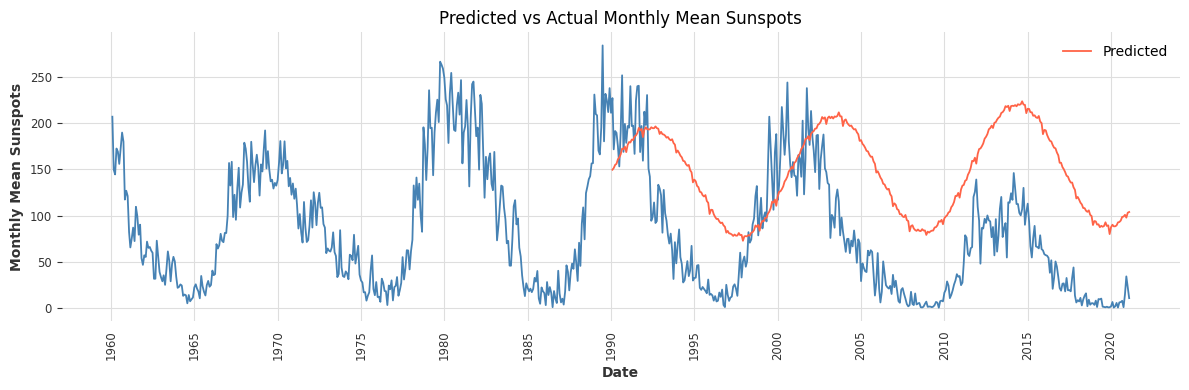

In [11]:
viz_forecast(df_pred_without_optimization)

## Optimizing the Parameters

In [12]:
#optimizing the model using Baeysian Optimization
def optimize_model(changepoint_prior_scale,tenY_seasonality_prior_scale,yearly_seasonality_prior_scale,ten_Y_fourier_order,yearly_fourier_order):
   #necessary paramters
    changepoint_prior_scale = round(changepoint_prior_scale, 2)
    tenY_seasonality_prior_scale = round(tenY_seasonality_prior_scale, 2)
    yearly_seasonality_prior_scale = round(yearly_seasonality_prior_scale, 2)
    ten_Y_fourier_order = int(ten_Y_fourier_order)
    yearly_fourier_order = int(yearly_fourier_order)
    
    params = {
        'changepoint_prior_scale': changepoint_prior_scale,
        'tenY_seasonality_prior_scale': tenY_seasonality_prior_scale,
        'yearly_seasonality_prior_scale': yearly_seasonality_prior_scale,
        'ten_Y_fourier_order': ten_Y_fourier_order,
        'yearly_fourier_order': yearly_fourier_order
    }

    #passing parameters to the model and getting the predicted dataframe
    forecast_df = model_prophet(params)

    #passing the dataframe for analysing the prediction and calculating the error in prediction
    return model_mean_error(forecast_df)*-1

In [13]:
#parameter space used to find best parameters
param_space = {
    'changepoint_prior_scale': (0.01, 0.5),  # Range for changepoint_prior_scale
    'tenY_seasonality_prior_scale': (9.0, 10.0),
    'yearly_seasonality_prior_scale': (0.01, 10.0),# Range for seasonality_prior_scale
    'ten_Y_fourier_order': (1, 20), 
    'yearly_fourier_order': (1, 20),          # Range for yearly_fourier_order
}

#Baeysian Optimization
optimizer = BayesianOptimization(
    f=optimize_model,
    pbounds=param_space,
    random_state=42
)

#initialising number of rounds with random parameters and targeted parameters 
optimizer.maximize(
    init_points=10,
    n_iter=20        # Number of iterations to perform
)

#optimize model to get minimum error
print(optimizer.max)

|   iter    |  target   | change... | tenY_s... | ten_Y_... | yearly... | yearly... |
-------------------------------------------------------------------------------------
| 1         | -43.82    | 0.1935    | 9.951     | 14.91     | 12.37     | 1.569     |
| 2         | -44.1     | 0.08644   | 9.058     | 17.46     | 12.42     | 7.084     |
| 3         | -82.04    | 0.02009   | 9.97      | 16.82     | 5.034     | 1.826     |
| 4         | -72.72    | 0.09987   | 9.304     | 10.97     | 9.207     | 2.919     |
| 5         | -63.58    | 0.3098    | 9.139     | 6.551     | 7.961     | 4.566     |
| 6         | -43.83    | 0.3947    | 9.2       | 10.77     | 12.26     | 0.474     |
| 7         | -44.69    | 0.3077    | 9.171     | 2.236     | 19.03     | 9.657     |
| 8         | -43.84    | 0.4061    | 9.305     | 2.856     | 14.0      | 4.407     |
| 9         | -45.63    | 0.0698    | 9.495     | 1.653     | 18.28     | 2.595     |
| 10        | -63.42    | 0.3346    | 9.312     | 10.8

## Forecasting using Prophet Model with Optimized Parameters

In [16]:
#visualizing the predictions made with optimized parameters
params = optimizer.max['params']
model_params_with_optimization =  {'changepoint_prior_scale': round(params['changepoint_prior_scale'],3), 
                                   'tenY_seasonality_prior_scale': round(params['tenY_seasonality_prior_scale'],3), 
                                   'ten_Y_fourier_order': int(params['ten_Y_fourier_order']),
                                   'yearly_fourier_order': int(params['ten_Y_fourier_order']), 
                                   'yearly_seasonality_prior_scale': round(params['yearly_seasonality_prior_scale'],3)}

df_pred_with_optimization = model_prophet(model_params_with_optimization)
print("Average error in the model:",round(model_mean_error(df_pred_with_optimization),2))

Average error in the model: 43.71


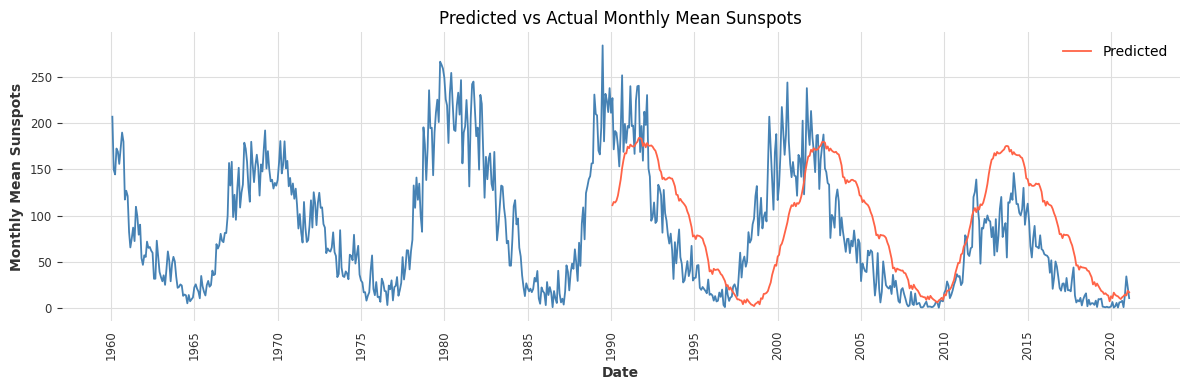

In [17]:
viz_forecast(df_pred_with_optimization)

## Comparison of Forecasting using Random Parameters vs Optimized Parameters

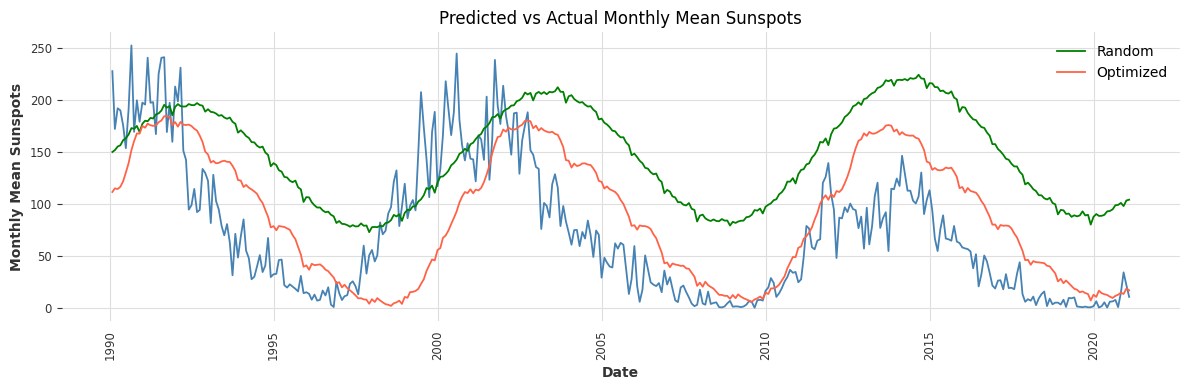

In [18]:
#comparing predictions made with random parameters and optimized parameters
plt.figure(figsize=[12,4])
plt.plot(df_idx['1990':].index,df_idx['1990':]['Monthly Mean Total Sunspot Number'],color='steelblue')
plt.plot(df_pred_without_optimization['Date'],df_pred_without_optimization['Monthly Mean Sunspot Predicted'],label='Random',color='g')
plt.plot(df_pred_with_optimization['Date'],df_pred_with_optimization['Monthly Mean Sunspot Predicted'],label='Optimized',color='#FF6347')
    
plt.xlabel('Date')
plt.ylabel('Monthly Mean Sunspots')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Predicted vs Actual Monthly Mean Sunspots')
plt.legend()
plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

In [19]:
print("Average error in the model for optimized parameters:",round(model_mean_error(df_pred_with_optimization),2))
print("Average error in the model for random parameters:",round(model_mean_error(df_pred_without_optimization),2))

Average error in the model for optimized parameters: 43.71
Average error in the model for random parameters: 82.64
